In [8]:
!pip install evaluate

In [9]:
!pip install --upgrade datasets transformers

In [10]:
# Import the necessary library's
import numpy as np
import pandas as pd
import re
import os
from imblearn.over_sampling import RandomOverSampler

from nltk.corpus import reuters
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset
from datasets import Dataset as HFDataset
from torch.optim import AdamW
from transformers import Trainer, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight

from transformers import DataCollatorWithPadding
from transformers import DistilBertTokenizer


import evaluate
import re
#  Download NLTK data files (run once)
nltk.download('reuters')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
df= pd.read_csv('/content/drive/MyDrive/Tweets.csv')

In [13]:

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [14]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [16]:
# Choose the important columns
data = df[['airline_sentiment', 'text']]
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


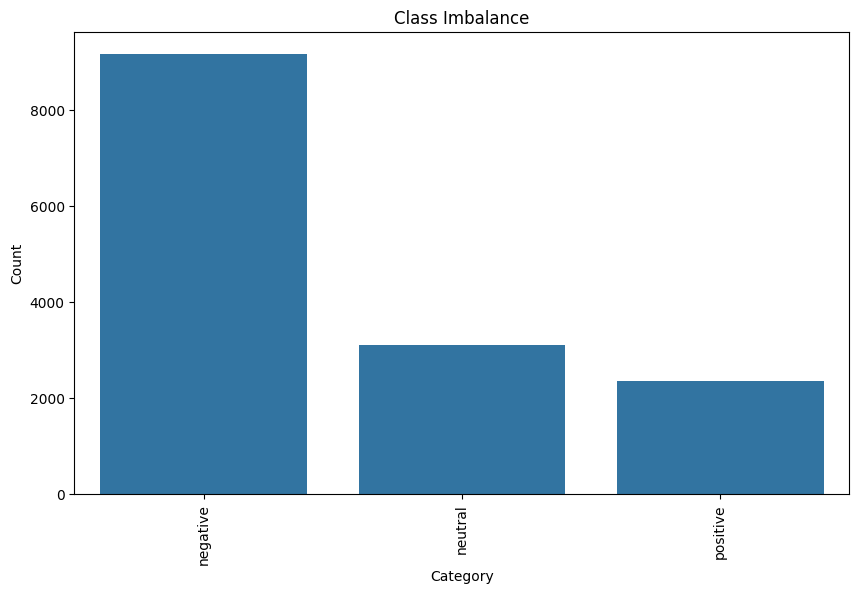

In [17]:
# Check class imbalance
category_counts = data['airline_sentiment'].value_counts()

# Plot class imbalance
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Class Imbalance")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [18]:
lemmatizer = WordNetLemmatizer()
# Step 1: Preprocessing
def preprocess(text):
    # Define a custom stopword list excluding negation words
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}

    # Lowercase the text
    text = text.lower()

    # Remove URLs but keep special characters like emojis and hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Tokenize into words
    words = word_tokenize(text)

    # Remove stopwords except negation words
    words = [word for word in words if word not in stop_words]

    # Join words back into a string
    return ' '.join(words)

# Apply preprocessing to the dataset
data['text'] = data['text'].apply(preprocess)

<ipython-input-18-133a8277b001>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(preprocess)


# Load and setup the pre-trained DistilBERT

In [19]:
# Step 2: Label Mapping
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
data['labels'] = data['airline_sentiment'].map(sentiment_map)

# Drop unnecessary columns
if 'sentiment' in data.columns:
    data.drop('sentiment', axis=1, inplace=True)


# Ensure labels are integers
data['labels'] = data['labels'].astype(int)

<ipython-input-19-ebe4a14381b7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['labels'] = data['airline_sentiment'].map(sentiment_map)
<ipython-input-19-ebe4a14381b7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['labels'] = data['labels'].astype(int)


In [20]:
# Debug: Check columns and data
print("Columns:", data.columns)
print("Data sample:", data[['text', 'labels']].head())
print("NaNs in labels:", data['labels'].isna().sum())
print("Label distribution:", data['labels'].value_counts())

Columns: Index(['airline_sentiment', 'text', 'labels'], dtype='object')
Data sample:                                                 text  labels
0                  @ virginamerica @ dhepburn said .       1
1  @ virginamerica plus 've added commercials exp...       2
2  @ virginamerica n't today ... must mean need t...       1
3  @ virginamerica 's really aggressive blast obn...       0
4            @ virginamerica 's really big bad thing       0
NaNs in labels: 0
Label distribution: labels
0    9178
1    3099
2    2363
Name: count, dtype: int64


In [21]:
# Step 3:Oversampling the data
X = data[['text']]
y = data['labels']
ros = RandomOverSampler(sampling_strategy={0: 9178, 1: 7000, 2: 7000}, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
data_resampled = pd.DataFrame({'text': X_resampled['text'], 'labels': y_resampled})
print("Resampled distribution:", data_resampled['labels'].value_counts())

Resampled distribution: labels
0    9178
1    7000
2    7000
Name: count, dtype: int64


In [22]:
# Step 4: Data Splitting (70-15-15)
train_data, temp_data = train_test_split(data_resampled, test_size=0.3, stratify=data_resampled['labels'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['labels'], random_state=42)

# Select needed columns
train_data = train_data[['text', 'labels']]
val_data = val_data[['text', 'labels']]
test_data = test_data[['text', 'labels']]

In [23]:
# Step 5: Convert to Hugging Face Datasets
train_dataset = HFDataset.from_pandas(train_data)
val_dataset = HFDataset.from_pandas(val_data)
test_dataset = HFDataset.from_pandas(test_data)

In [24]:
# Step 6: Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=128)
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/16224 [00:00<?, ? examples/s]

Map:   0%|          | 0/3477 [00:00<?, ? examples/s]

Map:   0%|          | 0/3477 [00:00<?, ? examples/s]

In [25]:
# Step 7: Set Dataset Format
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [41]:
# Step 8: Load Model and Training Arguments
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
model.config.id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
model.config.label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
model = model.to('cuda')

# Compute and tune class weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=data_resampled['labels'])
class_weights = np.clip(class_weights * [0.7, 1.3, 1.3], 0.5, 2.0)  # Boost neutral/positive
class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda')
print("Class Weights:", class_weights)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    logging_strategy='epoch',
    save_strategy='epoch',
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=8,
    learning_rate=2e-5,
    weight_decay=0.03,
    fp16=True,
    report_to='none',
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class Weights: tensor([0.5893, 1.4348, 1.4348], device='cuda:0')


In [42]:
# Step 9: Metrics
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)['accuracy']
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')['f1']
    return {'accuracy': accuracy, 'f1': f1}

In [43]:
# Step 10: Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [44]:
# Step 11: Custom Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.650700,0.498259,0.810469,0.811821
2,0.405400,0.415147,0.833765,0.835326
3,0.311700,0.357585,0.852747,0.852999
4,0.237800,0.334246,0.873167,0.873636
5,0.190200,0.320435,0.882657,0.883038
6,0.160100,0.325137,0.886684,0.886666
7,0.141600,0.326024,0.884958,0.885108
8,0.127300,0.325303,0.890998,0.891096


TrainOutput(global_step=1016, training_loss=0.27809465964009444, metrics={'train_runtime': 213.9416, 'train_samples_per_second': 606.67, 'train_steps_per_second': 4.749, 'total_flos': 1392902978447232.0, 'train_loss': 0.27809465964009444, 'epoch': 8.0})

In [47]:
save_path = "/content/drive/MyDrive/saved_models/Tweet_sentiment_distilbert_class_over4*"
os.makedirs(save_path, exist_ok=True)

# Save model and tokenizer
trainer.save_model(save_path)  # Saves both model and tokenizer

# Verify
print("Saved files:")
!ls -lh "{save_path}"

Saved files:
total 257M
-rw------- 1 root root  727 May 29 18:58 config.json
-rw------- 1 root root 256M May 29 18:58 model.safetensors
-rw------- 1 root root  125 May 29 18:58 special_tokens_map.json
-rw------- 1 root root 1.2K May 29 18:58 tokenizer_config.json
-rw------- 1 root root 695K May 29 18:58 tokenizer.json
-rw------- 1 root root 5.2K May 29 18:58 training_args.bin
-rw------- 1 root root 227K May 29 18:58 vocab.txt


In [50]:
# Ask Grock to make a full script to test the model.

# Step 1: Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Step 2: Define model checkpoint
model_info = {
    'name': 'Hybrid (9178/7000/7000)',
    'path': '/content/drive/MyDrive/saved_models/Tweet_sentiment_distilbert_class_over4*',
    'oversample': '9178/7000/7000',
    'weights': '[0.7, 1.3, 1.3]',
    'epochs': 8
}

# Step 3: Load model
try:
    model = DistilBertForSequenceClassification.from_pretrained(model_info['path']).to('cuda')
    model.config.id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
    model.config.label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Step 4: Define predict_sentiment function
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=1)[0].tolist()
    label = torch.argmax(logits, dim=1).item()
    sentiment = model.config.id2label[label]
    confidence = probs[label]
    probs_dict = {model.config.id2label[i]: prob for i, prob in enumerate(probs)}
    return sentiment, confidence, probs_dict

# Step 5: Test texts with expected labels
test_cases = [
    {'text': 'Flight was okay, nothing special.', 'expected': None},
    {'text': 'Amazing service, loved it!', 'expected': None},
    {'text': 'Delayed again, terrible.', 'expected': None},
    {'text': 'Bruh, this flick was straight fire, 10/10!', 'expected': None},
    {'text': 'This movie was hot garbage, total dumpster juice.', 'expected': None}
]

# Step 6: Run predictions
print(f"\nTesting Model: {model_info['name']}")
print(f"Oversample: {model_info['oversample']}, Weights: {model_info['weights']}, Epochs: {model_info['epochs']}\n")
for case in test_cases:
    text = case['text']
    expected = case['expected']
    sentiment, confidence, probs = predict_sentiment(text)
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {sentiment}, Confidence: {confidence:.4f}")
    print(f"Probabilities: {probs}")
    if expected:
        print(f"Expected Sentiment: {expected}, Match: {sentiment.lower() == expected.lower()}")
    print()


Testing Model: Hybrid (9178/7000/7000)
Oversample: 9178/7000/7000, Weights: [0.7, 1.3, 1.3], Epochs: 6

Text: Flight was okay, nothing special.
Predicted Sentiment: positive, Confidence: 0.7744
Probabilities: {'negative': 0.0752812847495079, 'neutral': 0.15026938915252686, 'positive': 0.7744492888450623}

Text: Amazing service, loved it!
Predicted Sentiment: positive, Confidence: 0.9927
Probabilities: {'negative': 0.0037023848854005337, 'neutral': 0.0036383739206939936, 'positive': 0.9926591515541077}

Text: Delayed again, terrible.
Predicted Sentiment: negative, Confidence: 0.9842
Probabilities: {'negative': 0.9841991662979126, 'neutral': 0.008435998111963272, 'positive': 0.007364895194768906}

Text: Bruh, this flick was straight fire, 10/10!
Predicted Sentiment: neutral, Confidence: 0.4002
Probabilities: {'negative': 0.2314336597919464, 'neutral': 0.4002338647842407, 'positive': 0.36833247542381287}

Text: This movie was hot garbage, total dumpster juice.
Predicted Sentiment: negati